In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 525 kB 5.1 MB/s 
     |████████████████████████████████| 132 kB 47.0 MB/s 
     |████████████████████████████████| 829 kB 18.9 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 332 kB 70.0 MB/s 
     |████████████████████████████████| 1.1 MB 39.7 MB/s 
     |████████████████████████████████| 160 kB 58.9 MB/s 
     |████████████████████████████████| 192 kB 52.0 MB/s 
     |████████████████████████████████| 271 kB 50.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=624984ee99e9b7be6e9345246be4131102facb96f857adaa2944ed842ac393bb
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
from torch import flatten
from torch import nn
from torch.nn import functional as F
import torch
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
from torch.utils.data import DataLoader, Dataset
import pickle
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.callbacks import LearningRateMonitor
from collections import OrderedDict

In [ ]:
rng = np.random.default_rng()

In [ ]:
batch_size = 128

In [ ]:
def draw_end2end_lines(n_lines = 1,
               width = 256,
               height = 256,
               buffer = 3,
               random_thickness = True):
  '''draws lines on image to simulate roads
     horizontal only, transformations will take care of vertical
     n_lines: int, the number of lines
     buffer: int, simulate real roads from our masks with buffer
     prefer_longer: bool, if true, assign heigher weight to the endpoints, so get longer lines
     '''
  #draw empty img
  canvas = np.zeros((width, height))
  pixels = np.arange(width)
  #add lines
  for line in range(n_lines):
    #thickness from buffer as in create_spacenet_masks
    if random_thickness:
      thickness = 6 + rng.integers(low=0, high=buffer)
    else:
      thickness = 6
    x_start = 0
    x_end = 255
    y_start = rng.choice(pixels, size= 1)
    y_end = rng.choice(pixels, 1)
    canvas = cv2.line(canvas, (x_start, y_start), (x_end, y_end), (255, 255, 255), thickness)
  return canvas

In [ ]:
def draw_lines(n_lines = 1,
               width = 256,
               height = 256,
               buffer = 3,
               prefer_longer = True,
               random_thickness = True):
  '''draws lines on image to simulate roads
     n_lines: int, the number of lines
     buffer: int, simulate real roads from our masks with buffer
     prefer_longer: bool, if true, assign heigher weight to the endpoints, so get longer lines
     '''
  #draw empty img
  canvas = np.zeros((width, height))
  pixels = np.arange(width)
  #weights
  if prefer_longer:
    p = ((pixels / pixels.sum()) + (np.flip(pixels)/pixels.sum())) / 2.0
  else:
    p = np.ones_like(pixels) / 256
  #add lines
  for line in range(n_lines):
    #thickness from buffer as in create_spacenet_masks
    if random_thickness:
      thickness = 6 + rng.integers(low=0, high=buffer)
    else:
      thickness = 6
    x_start = rng.choice(pixels, p = p, size = 1)
    x_end = rng.choice(pixels, p = p, size = 1)
    y_start = rng.choice(pixels, p = p, size= 1)
    y_end = rng.choice(pixels, p = p, size = 1)
    canvas = cv2.line(canvas, (x_start, y_start), (x_end, y_end), (255, 255, 255), thickness)
  return canvas

In [ ]:
def draw_rectangles(n_rect = 1,
               width = 256,
               height = 256,
               prefer_rectangles = True):
  '''draws rectangles on image to simulate buildings
     n_rect: int, the number of rects
     buffer: int, simulate real roads from our masks with buffer
     prefer_rect: bool, ToDo add functionality to add polygons
     '''
  #draw empty img
  canvas = np.zeros((width, height))
  pixels = np.arange(width)
  #add lines
  for rectangle in range(n_rect):
    #thickness from buffer as in create_spacenet_masks
    x_start = rng.choice(pixels, size = 1)
    y_start = rng.choice(pixels, size= 1)
    if x_start == 255 or y_start == 255:
      continue
    x_end = rng.choice(pixels[pixels > x_start], 1)
    
    y_end = rng.choice(pixels[pixels > y_start], 1)
    canvas = cv2.rectangle(canvas, (x_start, y_start), (x_end, y_end), (255, 255, 255), -1)
  #do a small rotation  
  angle = rng.integers(low = 0, high = 90)
  center_x, center_y = width // 2, height // 2
  M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
  rotated = cv2.warpAffine(canvas, M, (width, height))
  return rotated

In [ ]:
def draw_circles(n_circles = 1,
               width = 256,
               height = 256,
               buffer = 3,
               prefer_rectangles = True):
  '''draws circular shapes
     n_lines: int, the number of lines
     buffer: int, simulate real roads from our masks with buffer
     prefer_longer: bool, if true, assign heigher weight to the endpoints, so get longer lines
     '''
  #draw empty img
  canvas = np.zeros((width, height))
  pixels = np.arange(width)
  WHITE = (255, 255, 255)
  #add lines
  for circle in range(n_circles):
    #thickness from buffer as in create_spacenet_masks
    angle = rng.integers(low = 0, high = 90)
    center = rng.choice(pixels, size = 1), rng.choice(pixels, 1)
    axes = rng.integers(low = 5, high = width), rng.integers(low = 5, high = width)
    canvas = cv2.ellipse(canvas, center, axes, angle, 0, 360, WHITE, -1)
  return canvas

In [ ]:
class ShapeDataset(Dataset):
    def __init__(self, shapes = {0:"lines", 1:"rects", 2:"circles"}):
        #self.data = data 
        self.shapes = shapes
        self.one_hot = np.zeros(len(shapes))
        
    
    def __getitem__(self, idx: int):
        shape = rng.choice(np.arange(len(self.shapes)))
        if shape == 0:
          if rng.choice([0,1]):
            img = draw_lines(rng.integers(low = 1, high = 5))
          else:
            img = draw_end2end_lines(rng.integers(low = 1, high = 5))

        elif shape == 1:
          img = draw_rectangles(rng.integers(low = 1, high = 20))

        elif shape == 2:
          img = draw_circles(rng.integers(low = 1, high = 5))
        class_vector = self.one_hot
        class_vector[shape] = 1
        img = np.expand_dims(img, axis=0)
        img = img /  255.0
        return img, shape
      
    def __len__(self):
        return batch_size
    
    #def __len__(self):
    #   return len(self.data)

In [ ]:
class ShapeNet(LightningModule):

  def __init__(self, in_channels=1, hidden_dim=16, n_classes=3, lr = 0.001):
    self.lr = lr
    super(ShapeNet, self).__init__()
    self.conv1 = self.conv_block(in_channels, hidden_dim)
    self.conv2 = self.conv_block(hidden_dim, hidden_dim * 2)
    self.conv3 = self.conv_block(hidden_dim * 2, hidden_dim * 4, final_layer=True)
    self.fc = nn.Linear(in_features = 3136, out_features = n_classes)
   
  def conv_block(self, in_channels, out_channels, kernel_size = 3, stride = 2, final_layer=False):
    if not final_layer:
            return nn.Sequential(OrderedDict([
                ("Conv2d", nn.Conv2d(in_channels, out_channels, kernel_size, stride)),
                ("BatchNorm", nn.BatchNorm2d(out_channels)),
                ("MaxPool", nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))),
                ("LeakyRelu", nn.LeakyReLU(0.2, inplace=True))
            ])
            )
    else: 
        return nn.Sequential(OrderedDict([
            ("final", nn.Conv2d(in_channels, out_channels, kernel_size, stride))
        ])
        )
  def forward(self, x):
    # pass the input through our first set of CONV => RELU =>
    # POOL layers
    x = self.conv1(x.float())
    x = self.conv2(x)
    x = self.conv3(x)
    x = flatten(x, start_dim=1)
    x = self.fc(x)
    x = F.log_softmax(x, dim=1)
    return x

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y, reduction = 'mean')
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.nll_loss(logits, y, reduction = 'mean')
    self.log("step_val_loss", loss)
    return {"step_val_loss": loss}

  def validation_epoch_end(self, validation_step_outputs):
    avg_loss = torch.stack([x['step_val_loss'] for x in validation_step_outputs]).mean()
    print(f"validation loss {avg_loss}")
    self.log("val_loss", avg_loss)
    return {"val_loss": avg_loss}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    lr_scheduler = {
        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.2, patience = 5),
        'monitor': 'val_loss'
    }
    return [optimizer], [lr_scheduler]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from pytorch_lightning import LightningModule, Trainer, seed_everything

In [ ]:
ds = ShapeDataset()
val_ds = ShapeDataset()
dataloader = DataLoader(ds, batch_size = batch_size)
val = DataLoader(val_ds, batch_size = batch_size)

In [ ]:
images, labels = next(iter(dataloader))

In [ ]:
images.shape

torch.Size([128, 1, 256, 256])

In [ ]:
model = ShapeNet().float()
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = Trainer(callbacks=[lr_monitor], gpus = 0)
trainer.fit(model, train_dataloaders = dataloader, val_dataloaders = val)

validation loss 0.2729371190071106


Validating: 0it [00:00, ?it/s]

validation loss 0.14005102217197418


Validating: 0it [00:00, ?it/s]

validation loss 0.2300390899181366


Validating: 0it [00:00, ?it/s]

validation loss 0.17172306776046753


Validating: 0it [00:00, ?it/s]

validation loss 0.2410014420747757


Validating: 0it [00:00, ?it/s]

validation loss 0.24116815626621246


Validating: 0it [00:00, ?it/s]

validation loss 0.23904772102832794


Validating: 0it [00:00, ?it/s]

validation loss 0.20720520615577698


Validating: 0it [00:00, ?it/s]

validation loss 0.2252098172903061


Validating: 0it [00:00, ?it/s]

validation loss 0.20058514177799225


Validating: 0it [00:00, ?it/s]

validation loss 0.18265368044376373


Validating: 0it [00:00, ?it/s]

validation loss 0.23969265818595886


Validating: 0it [00:00, ?it/s]

validation loss 0.24909210205078125


Validating: 0it [00:00, ?it/s]

validation loss 0.219163715839386


Validating: 0it [00:00, ?it/s]

validation loss 0.2494916468858719


Validating: 0it [00:00, ?it/s]

validation loss 0.20005090534687042


Validating: 0it [00:00, ?it/s]

validation loss 0.19914031028747559


Validating: 0it [00:00, ?it/s]

validation loss 0.2626279592514038


Validating: 0it [00:00, ?it/s]

validation loss 0.22769388556480408


Validating: 0it [00:00, ?it/s]

validation loss 0.25837230682373047


Validating: 0it [00:00, ?it/s]

validation loss 0.22570231556892395


Validating: 0it [00:00, ?it/s]

validation loss 0.22914674878120422


Validating: 0it [00:00, ?it/s]

validation loss 0.25290802121162415


Validating: 0it [00:00, ?it/s]

validation loss 0.22772173583507538


Validating: 0it [00:00, ?it/s]

validation loss 0.21665099263191223


Validating: 0it [00:00, ?it/s]

validation loss 0.2445434331893921


Validating: 0it [00:00, ?it/s]

validation loss 0.2565003037452698


Validating: 0it [00:00, ?it/s]

validation loss 0.17666907608509064


Validating: 0it [00:00, ?it/s]

validation loss 0.17523649334907532


Validating: 0it [00:00, ?it/s]

validation loss 0.21249078214168549


Validating: 0it [00:00, ?it/s]

validation loss 0.20221161842346191


Validating: 0it [00:00, ?it/s]

validation loss 0.15328118205070496


Validating: 0it [00:00, ?it/s]

validation loss 0.2917329967021942


Validating: 0it [00:00, ?it/s]

validation loss 0.2103356271982193


Validating: 0it [00:00, ?it/s]

validation loss 0.24715828895568848


Validating: 0it [00:00, ?it/s]

validation loss 0.17099575698375702


Validating: 0it [00:00, ?it/s]

validation loss 0.20722614228725433


Validating: 0it [00:00, ?it/s]

validation loss 0.24769365787506104


Validating: 0it [00:00, ?it/s]

validation loss 0.26494458317756653


Validating: 0it [00:00, ?it/s]

validation loss 0.256328284740448


Validating: 0it [00:00, ?it/s]

validation loss 0.23893292248249054


Validating: 0it [00:00, ?it/s]

validation loss 0.17532838881015778


Validating: 0it [00:00, ?it/s]

validation loss 0.15632058680057526


Validating: 0it [00:00, ?it/s]

validation loss 0.2440827339887619


Validating: 0it [00:00, ?it/s]

validation loss 0.20545095205307007


Validating: 0it [00:00, ?it/s]

validation loss 0.20308762788772583


Validating: 0it [00:00, ?it/s]

validation loss 0.2356444150209427


Validating: 0it [00:00, ?it/s]

validation loss 0.20726647973060608


Validating: 0it [00:00, ?it/s]

validation loss 0.20405471324920654


Validating: 0it [00:00, ?it/s]

validation loss 0.2324945032596588


Validating: 0it [00:00, ?it/s]

validation loss 0.221408411860466


Validating: 0it [00:00, ?it/s]

validation loss 0.1683456152677536


Validating: 0it [00:00, ?it/s]

validation loss 0.21380628645420074


Validating: 0it [00:00, ?it/s]

validation loss 0.1784483939409256


Validating: 0it [00:00, ?it/s]

validation loss 0.20585842430591583


Validating: 0it [00:00, ?it/s]

validation loss 0.1940569132566452


Validating: 0it [00:00, ?it/s]

validation loss 0.25288110971450806


Validating: 0it [00:00, ?it/s]

validation loss 0.22368232905864716


Validating: 0it [00:00, ?it/s]

validation loss 0.20632855594158173


Validating: 0it [00:00, ?it/s]

validation loss 0.20165355503559113


Validating: 0it [00:00, ?it/s]

validation loss 0.2331514209508896


Validating: 0it [00:00, ?it/s]

validation loss 0.24135833978652954


Validating: 0it [00:00, ?it/s]

validation loss 0.22888022661209106


Validating: 0it [00:00, ?it/s]

validation loss 0.24431133270263672


Validating: 0it [00:00, ?it/s]

validation loss 0.22842420637607574


Validating: 0it [00:00, ?it/s]

validation loss 0.3000955879688263


Validating: 0it [00:00, ?it/s]

validation loss 0.1966504007577896


Validating: 0it [00:00, ?it/s]

validation loss 0.2662087082862854


Validating: 0it [00:00, ?it/s]

validation loss 0.2662941813468933


Validating: 0it [00:00, ?it/s]

validation loss 0.2277299463748932


Validating: 0it [00:00, ?it/s]

validation loss 0.191635861992836


Validating: 0it [00:00, ?it/s]

validation loss 0.20323950052261353


Validating: 0it [00:00, ?it/s]

validation loss 0.17912302911281586


Validating: 0it [00:00, ?it/s]

validation loss 0.28057801723480225


Validating: 0it [00:00, ?it/s]

validation loss 0.24746961891651154


Validating: 0it [00:00, ?it/s]

validation loss 0.23524628579616547


Validating: 0it [00:00, ?it/s]

validation loss 0.24943439662456512


Validating: 0it [00:00, ?it/s]

validation loss 0.18611262738704681


Validating: 0it [00:00, ?it/s]

validation loss 0.21067766845226288


Validating: 0it [00:00, ?it/s]

validation loss 0.19262301921844482


Validating: 0it [00:00, ?it/s]

validation loss 0.21887603402137756


Validating: 0it [00:00, ?it/s]

validation loss 0.1488994061946869


Validating: 0it [00:00, ?it/s]

validation loss 0.2100345492362976


Validating: 0it [00:00, ?it/s]

validation loss 0.19532452523708344


Validating: 0it [00:00, ?it/s]

validation loss 0.19161352515220642


Validating: 0it [00:00, ?it/s]

validation loss 0.2298765331506729


Validating: 0it [00:00, ?it/s]

validation loss 0.2120351791381836


Validating: 0it [00:00, ?it/s]

validation loss 0.22647735476493835


Validating: 0it [00:00, ?it/s]

validation loss 0.22419027984142303


Validating: 0it [00:00, ?it/s]

validation loss 0.21219423413276672


Validating: 0it [00:00, ?it/s]

validation loss 0.19183550775051117


Validating: 0it [00:00, ?it/s]

validation loss 0.1919393390417099


Validating: 0it [00:00, ?it/s]

validation loss 0.20639656484127045


Validating: 0it [00:00, ?it/s]

validation loss 0.23394736647605896


Validating: 0it [00:00, ?it/s]

validation loss 0.25280728936195374


Validating: 0it [00:00, ?it/s]

validation loss 0.27643486857414246


Validating: 0it [00:00, ?it/s]

validation loss 0.18450674414634705


Validating: 0it [00:00, ?it/s]

validation loss 0.15372681617736816


Validating: 0it [00:00, ?it/s]

validation loss 0.24166303873062134


Validating: 0it [00:00, ?it/s]

validation loss 0.20311136543750763


Validating: 0it [00:00, ?it/s]

validation loss 0.25103187561035156


Validating: 0it [00:00, ?it/s]

validation loss 0.2986263632774353


Validating: 0it [00:00, ?it/s]

validation loss 0.26168888807296753


Validating: 0it [00:00, ?it/s]

validation loss 0.28569498658180237


Validating: 0it [00:00, ?it/s]

validation loss 0.2161470502614975


Validating: 0it [00:00, ?it/s]

validation loss 0.17811305820941925


Validating: 0it [00:00, ?it/s]

validation loss 0.23316416144371033


Validating: 0it [00:00, ?it/s]

validation loss 0.29162025451660156


Validating: 0it [00:00, ?it/s]

validation loss 0.19956807792186737


Validating: 0it [00:00, ?it/s]

validation loss 0.26590853929519653


Validating: 0it [00:00, ?it/s]

validation loss 0.23747168481349945


Validating: 0it [00:00, ?it/s]

validation loss 0.20124071836471558


Validating: 0it [00:00, ?it/s]

validation loss 0.20006217062473297


Validating: 0it [00:00, ?it/s]

validation loss 0.2934987545013428


Validating: 0it [00:00, ?it/s]

validation loss 0.16336266696453094


Validating: 0it [00:00, ?it/s]

validation loss 0.17625030875205994


Validating: 0it [00:00, ?it/s]

validation loss 0.2334141582250595


Validating: 0it [00:00, ?it/s]

validation loss 0.23052391409873962


Validating: 0it [00:00, ?it/s]

validation loss 0.1794923096895218


Validating: 0it [00:00, ?it/s]

validation loss 0.1907406747341156


Validating: 0it [00:00, ?it/s]

validation loss 0.24594435095787048


Validating: 0it [00:00, ?it/s]

validation loss 0.24492259323596954


Validating: 0it [00:00, ?it/s]

validation loss 0.2012212872505188


Validating: 0it [00:00, ?it/s]

validation loss 0.17227120697498322


Validating: 0it [00:00, ?it/s]

validation loss 0.13434311747550964


Validating: 0it [00:00, ?it/s]

validation loss 0.20366966724395752


Validating: 0it [00:00, ?it/s]

validation loss 0.19782009720802307


Validating: 0it [00:00, ?it/s]

validation loss 0.24950569868087769


Validating: 0it [00:00, ?it/s]

validation loss 0.23792849481105804


Validating: 0it [00:00, ?it/s]

validation loss 0.2320544272661209


Validating: 0it [00:00, ?it/s]

validation loss 0.1674678474664688


Validating: 0it [00:00, ?it/s]

validation loss 0.16632215678691864


Validating: 0it [00:00, ?it/s]

validation loss 0.2052891105413437


Validating: 0it [00:00, ?it/s]

validation loss 0.2400503307580948


Validating: 0it [00:00, ?it/s]

validation loss 0.32382863759994507


Validating: 0it [00:00, ?it/s]

validation loss 0.23415079712867737


Validating: 0it [00:00, ?it/s]

validation loss 0.20514319837093353


Validating: 0it [00:00, ?it/s]

validation loss 0.2639366388320923


Validating: 0it [00:00, ?it/s]

validation loss 0.2522675096988678


Validating: 0it [00:00, ?it/s]

validation loss 0.2435319423675537


Validating: 0it [00:00, ?it/s]

validation loss 0.22648359835147858


Validating: 0it [00:00, ?it/s]

validation loss 0.3280288279056549


Validating: 0it [00:00, ?it/s]

validation loss 0.19294491410255432


Validating: 0it [00:00, ?it/s]

validation loss 0.26376014947891235


Validating: 0it [00:00, ?it/s]

validation loss 0.2668587565422058


Validating: 0it [00:00, ?it/s]

validation loss 0.2558777630329132


Validating: 0it [00:00, ?it/s]

validation loss 0.20502029359340668


Validating: 0it [00:00, ?it/s]

validation loss 0.33502671122550964


Validating: 0it [00:00, ?it/s]

validation loss 0.19350820779800415


Validating: 0it [00:00, ?it/s]

validation loss 0.24282509088516235


Validating: 0it [00:00, ?it/s]

validation loss 0.2227824181318283


Validating: 0it [00:00, ?it/s]

validation loss 0.21227207779884338


Validating: 0it [00:00, ?it/s]

validation loss 0.24163693189620972


Validating: 0it [00:00, ?it/s]

validation loss 0.18291665613651276


Validating: 0it [00:00, ?it/s]

validation loss 0.2286837100982666


Validating: 0it [00:00, ?it/s]

validation loss 0.20670562982559204


Validating: 0it [00:00, ?it/s]

validation loss 0.23693811893463135


Validating: 0it [00:00, ?it/s]

validation loss 0.14099223911762238


Validating: 0it [00:00, ?it/s]

validation loss 0.20786604285240173


Validating: 0it [00:00, ?it/s]

validation loss 0.2507632076740265


Validating: 0it [00:00, ?it/s]

validation loss 0.2378251552581787


Validating: 0it [00:00, ?it/s]

validation loss 0.29001548886299133


Validating: 0it [00:00, ?it/s]

validation loss 0.23490650951862335


Validating: 0it [00:00, ?it/s]

validation loss 0.23072822391986847


Validating: 0it [00:00, ?it/s]

validation loss 0.18233609199523926


Validating: 0it [00:00, ?it/s]

validation loss 0.2616270184516907


Validating: 0it [00:00, ?it/s]

validation loss 0.24947325885295868


Validating: 0it [00:00, ?it/s]

validation loss 0.17988017201423645


Validating: 0it [00:00, ?it/s]

validation loss 0.21932412683963776


Validating: 0it [00:00, ?it/s]

validation loss 0.21528001129627228


Validating: 0it [00:00, ?it/s]

validation loss 0.23903273046016693


Validating: 0it [00:00, ?it/s]

validation loss 0.2695474624633789


Validating: 0it [00:00, ?it/s]

validation loss 0.30199167132377625


Validating: 0it [00:00, ?it/s]

validation loss 0.19218839704990387


Validating: 0it [00:00, ?it/s]

validation loss 0.17907382547855377


Validating: 0it [00:00, ?it/s]

validation loss 0.21303950250148773


Validating: 0it [00:00, ?it/s]

validation loss 0.3385944366455078


Validating: 0it [00:00, ?it/s]

validation loss 0.27052584290504456


Validating: 0it [00:00, ?it/s]

validation loss 0.19757220149040222


Validating: 0it [00:00, ?it/s]

validation loss 0.2229805439710617


Validating: 0it [00:00, ?it/s]

validation loss 0.25568535923957825


Validating: 0it [00:00, ?it/s]

validation loss 0.22130468487739563


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
batch = next(iter(dataloader))

In [ ]:
batch[0].shape

torch.Size([128, 1, 256, 256])

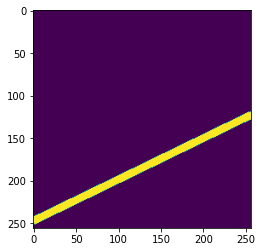

In [ ]:
plt.imshow(torch.squeeze(batch[0][6]))

In [ ]:
preds = model(batch[0])

In [ ]:
preds = preds.cpu().detach().numpy()

In [ ]:
batch[1]

tensor([1, 1, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1,
        0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1,
        2, 0, 1, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1,
        2, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1,
        1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2,
        2, 1, 0, 0, 1, 0, 1, 0])

In [ ]:
np.argmax(preds, axis=1)

array([1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2,
       1, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0,
       1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0])

In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/ai4good/shapenet/shapenet.ckpt")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ai4good/shapenet/shapenet.pth')